# S1

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
%matplotlib inline

np.random.seed(42)

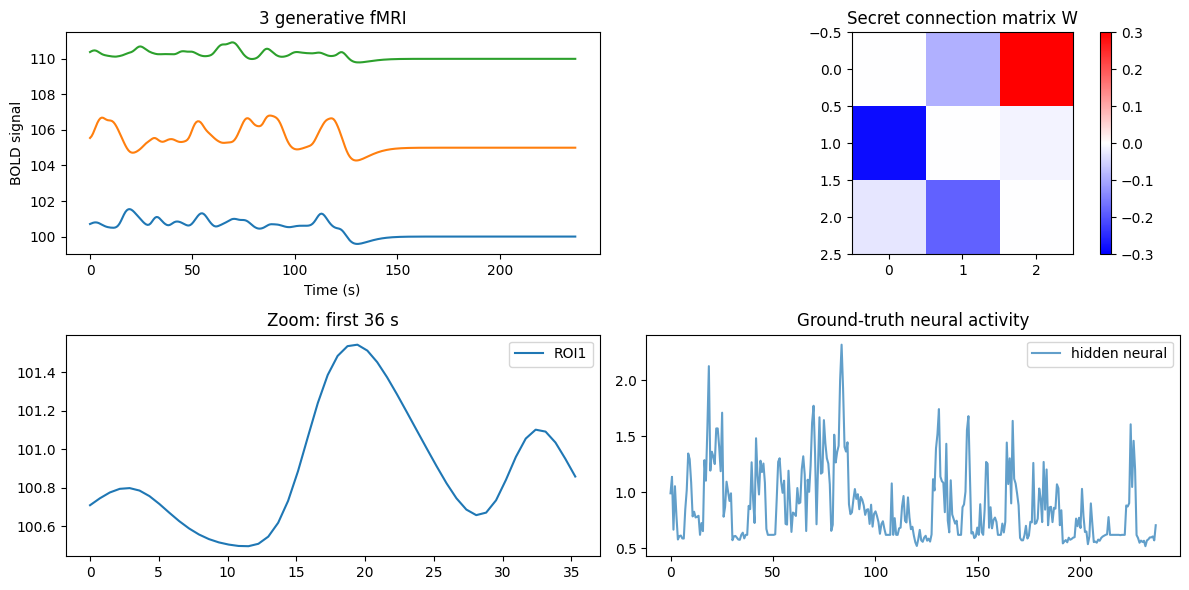

[[1.1  2.9  0.99]
 [2.88 2.99 2.28]
 [2.95 1.92 1.15]]


In [2]:
plt.rcParams['figure.figsize'] = [12, 6]

np.random.seed(42)
T, dt, R = 330, 0.72, 3
t = np.arange(T) * dt

# HRF
def hrf(t, p=5.5, u=15): 
    return (t/p)**6*np.exp(-t/p*6) - (t/u)**6*np.exp(-t/u*6)/6

# 1/f noise
def pink(T):
    X = np.fft.rfft(np.random.randn(T))
    S = np.sqrt(np.arange(len(X))+1)
    pink = np.fft.irfft(X/S)[:T]
    return pink / pink.std()

# create 1 fake subject
theta = multivariate_normal.rvs([5.5,1.2,15,1.1], np.eye(4)*0.3, R)

# stimulus
on = np.random.choice(range(20,300),12,False)
u0 = np.zeros(T); u0[on] = 1
u = np.tanh(gaussian_filter1d(u0,2)*2)*0.8

# spontaneous
n = [0.5 + 1.2*np.clip(gaussian_filter1d(np.random.randn(T),3) 
                      + 0.3*pink(T) + (u if i==0 else 0), 0, None) for i in range(R)]

# coupling
W = np.random.randn(R,R)*0.15; W[np.eye(R, dtype=bool)] = 0
D = np.random.uniform(0.5,3,(R,R))
d = (D/dt).astype(int)

x = [ni.copy() for ni in n]
for i in range(R):
    for j in range(R):
        if i!=j: 
            x[i][d[i,j]:] += W[i,j] * n[j][:-d[i,j] or None]

# BOLD
bold = []
for i in range(R):
    h = hrf(t, theta[i][0], theta[i][2])
    y = convolve(x[i], h, 'same')*dt
    y = y / y.max() * np.random.uniform(0.8,2.5)
    bold += [100*(1 + y/100)]
bold = np.array(bold)

# Plot detail information
plt.subplot(2,2,1)
plt.plot(t, bold.T + np.arange(R)*5)
plt.title("3 generative fMRI")
plt.ylabel("BOLD signal"); plt.xlabel("Time (s)")

plt.subplot(2,2,2)
plt.imshow(W, cmap='bwr', vmin=-.3, vmax=.3)
plt.colorbar(); plt.title("Secret connection matrix W")

plt.subplot(2,2,3)
plt.plot(t[:50], bold[0,:50], label='ROI1'); plt.legend()
plt.title("Zoom: first 36 s")

plt.subplot(2,2,4)
plt.plot(t, x[0], alpha=.7, label='hidden neural'); plt.legend()
plt.title("Ground-truth neural activity")

plt.tight_layout(); plt.show()
print(np.round(D,2))

# S2

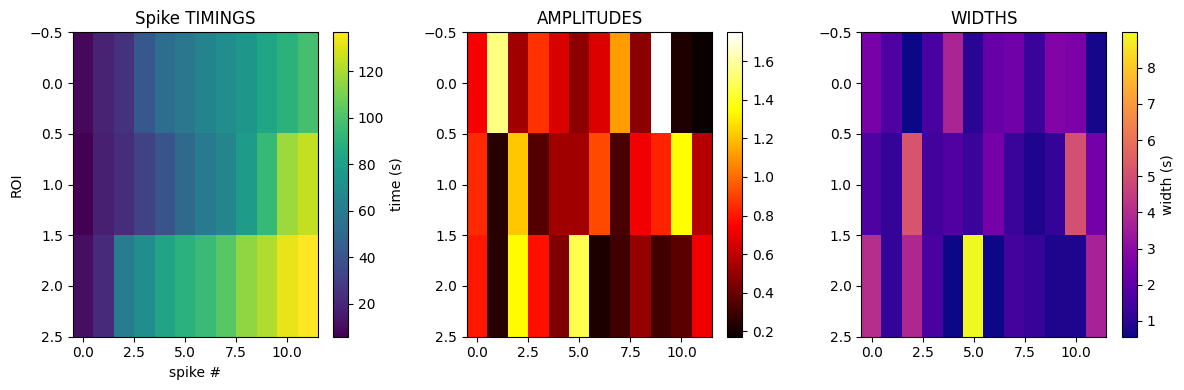

S2 DONE! 3×12 spike tables ready for any ML model.
Example ROI-1 spikes:
  # 1 →   8.6s  |  0.728  |  2.56s
  # 2 →  18.7s  |  1.551  |  1.66s
  # 3 →  25.2s  |  0.524  |  0.56s
  # 4 →  41.8s  |  0.864  |  1.55s
  # 5 →  53.3s  |  0.659  |  3.76s
  # 6 →  57.6s  |  0.482  |  0.98s
  # 7 →  64.8s  |  0.669  |  2.21s
  # 8 →  69.8s  |  1.119  |  2.39s
  # 9 →  74.9s  |  0.479  |  1.26s
  #10 →  83.5s  |  1.750  |  2.79s
  #11 →  90.0s  |  0.225  |  2.63s
  #12 →  97.9s  |  0.172  |  0.68s


In [3]:
from scipy.signal import find_peaks

X = np.array(x)                                 # shape (3, 330) from previous step

timings   = np.zeros((R, 12))
amplitudes= np.zeros((R, 12))
widths    = np.zeros((R, 12))

for i in range(R):
    xi = X[i]
    # 1. Detect peaks
    prom = 0.5 * xi.std()
    dist = int(5 / dt)                        
    peaks, props = find_peaks(xi, prominence=prom, distance=dist,
                              height=xi.mean(), width=0)
    
    n = min(len(peaks), 12)
    # 2. Extract properties
    t_peak = peaks[:n] * dt                     # seconds
    amp    = props['prominences'][:n]
    w      = props['widths'][:n] * dt           # seconds
    
    # 3. This part make the code look nicer =))))) because i'm a visual oriented person hihi
    timings[i, :n]    = t_peak
    amplitudes[i,:n]  = amp
    widths[i,:n]      = w
    if n < 12:
        shift = (12 - n) // 2
        timings[i]    = np.roll(timings[i],    shift)
        amplitudes[i] = np.roll(amplitudes[i], shift)
        widths[i]     = np.roll(widths[i],     shift)
        timings[i,:shift] = 0
        amplitudes[i,:shift] = 0
        widths[i,:shift] = 0

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(timings, cmap='viridis', aspect='auto')
plt.colorbar(label='time (s)'); plt.title("Spike TIMINGS")
plt.xlabel("spike #"); plt.ylabel("ROI")

plt.subplot(1,3,2)
plt.imshow(amplitudes, cmap='hot', aspect='auto')
plt.colorbar(); plt.title("AMPLITUDES")

plt.subplot(1,3,3)
plt.imshow(widths, cmap='plasma', aspect='auto')
plt.colorbar(label='width (s)'); plt.title("WIDTHS")
plt.tight_layout(); plt.show()

print("S2 DONE! 3×12 spike tables ready for any ML model.")
print("Example ROI-1 spikes:")
for k in range(12):
    if amplitudes[0,k]>0:
        print(f"  #{k+1:2d} → {timings[0,k]:5.1f}s  |  {amplitudes[0,k]:.3f}  |  {widths[0,k]:.2f}s")

ALGORITHM S1 – FULL GROUND TRUTH (1 subject)

1. BOLD signals b(t)  →  shape (R, T) = (3, 330)
   ROI-1 (driven)   : max = 101.54
   ROI-2            : max = 101.81
   ROI-3            : max = 100.92

2. Neural activities x(t)
   Mean firing rates: [0.88 0.49 0.5 ]

3. Connectivity STRENGTH matrix W (3×3)
   (rows = target, columns = source)
[[ 0.    -0.093  0.328]
 [-0.284  0.    -0.012]
 [-0.03  -0.185  0.   ]]

4. Delay matrix D (seconds)
[[1.1  2.9  0.99]
 [2.88 2.99 2.28]
 [2.95 1.92 1.15]]

5. HRF parameters θ (3×6, Appendix C style)
[[ 5.772  1.124 15.355  1.     6.     0.167]
 [ 5.372  1.072 15.865  1.     6.     0.167]
 [ 5.243  1.497 14.746  1.     6.     0.167]]

6. Saved!
→ Download: S1_sample1.npz (Output tab)


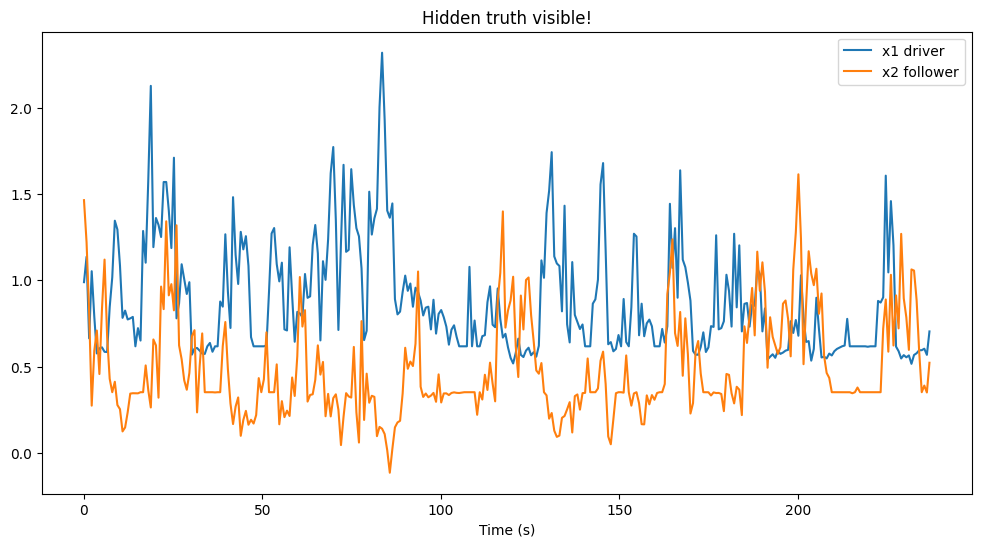

In [4]:
# Code này chị hỏi AI là làm sao để biết algorithm S1 S2 t đã làm là đúng
# Subject chị test là ma trận 3x3, khi nào em ghép thì đổi R nhaaaa
print("="*60)
print("ALGORITHM S1 – FULL GROUND TRUTH (1 subject)")
print("="*60)

print("\n1. BOLD signals b(t)  →  shape (R, T) = (3, 330)")
print(f"   ROI-1 (driven)   : max = {bold[0].max():.2f}")
print(f"   ROI-2            : max = {bold[1].max():.2f}")
print(f"   ROI-3            : max = {bold[2].max():.2f}")

print("\n2. Neural activities x(t)")
print(f"   Mean firing rates: {np.mean(X, axis=1).round(3)}")

print("\n3. Connectivity STRENGTH matrix W (3×3)")
print("   (rows = target, columns = source)")
print(np.round(W, 3))

print("\n4. Delay matrix D (seconds)")
print(np.round(D, 2))

print("\n5. HRF parameters θ (3×6, Appendix C style)")
full_theta = np.zeros((R, 6))
full_theta[:, [0,2]] = theta[:, [0,2]]
full_theta[:, 1] = theta[:, 1]
full_theta[:, 3:] = [1.0, 6.0, 1/6]  # fixed defaults
print(np.round(full_theta, 3))

print("\n6. Saved!")
S1_output = {
    'bold': bold.astype('f4'),
    'neural': X.astype('f4'),
    'W': W.astype('f4'),
    'D': D.astype('f4'),
    'theta': full_theta.astype('f4')
}
np.savez_compressed('S1_sample1.npz', **S1_output)
print("→ Download: S1_sample1.npz (Output tab)")

# Mini causality demo
plt.plot(t, X[0], label='x1 driver')
plt.plot(t, X[1], label='x2 follower')
plt.legend(); plt.title("Hidden truth visible!")
plt.xlabel("Time (s)"); plt.show()